# Review process for generating steady state conditions

To generate steady state, conditions, we make the call to StaticPlug defined [here](https://github.com/fredriclam/compressible-conduit-steady/commit/6175d7bb2496a4eaec168652a5d2815d9e09bf23#diff-59583c6549aedc1320306f24a60f924336cce62afd3bbe5927e5a9f82b44c6d5R1211).

Static plug solves ODEs and returns two possible outputs:
1. p (pressure array)
2. U (computed state variables)

I am not totally sure why Fred removed the the link to fragmentation criterion. But he did [here](https://github.com/fredriclam/compressible-conduit-steady/blob/main/steady_state.py#L1468-L1474). As it is, I don't think fragmentation is actually being considered at all. 

## Notes from Fred's email 05/14

- StaticPlug (rewritten from SteadyState class to speclize in zero velocity case)
- In theory no velocity means no fragmentation or exsolution


Suggestions:
1. **turn off exsolution in unsteady solver.** That is sufficient to stop the quail solution from behaving badly. 
2. **Add clippings to the exsolved water vapor used in the Static plug to be at least 1e-7** I made this change and it did not appear to help the situation 
3. **Does increasing the exsolution time source help?** Increasing the exsolution time to 1s is sufficient to resolve the issue. Even just increasing the exsolution time scale to 1e-2 s is sufficient to largely resolve the issue. 


## Questions 
- Is it acceptable to have the exsolution time scale increased? 
- The huge errors when the exsolution timescale is too small seems to imply that the exsolutiuon source may have a bug in it? 


In [7]:
# Import standard libraries
import matplotlib.pyplot as plt
import numpy as np
import os

# Modify base path for depending on your file structure.
BASE_PATH = "/Users/paxton/git"

# Specify path for Quail source code
source_dir = f"{BASE_PATH}/quail_volcano/src"
target_dir = f"{BASE_PATH}/volcano_sims/notebooks"

# Import quail modules
os.chdir(source_dir)

# Import steady_state module
import compressible_conduit_steady.steady_state as steady_state



In [8]:
R = 10
f_plug = 1.9e8
len_plug = 50

t_plug = f_plug/(2*np.pi*R*len_plug) # [N / m^2]
trac_par = 2*t_plug/R # [N / m^3]

print(t_plug)

N_mesh_points = 400

x_mesh = np.linspace(-1000, 0, N_mesh_points)[:,np.newaxis,np.newaxis]
# Chamber pressure is not used, so we pass a dummy value
p_chamber = None
# Set vent pressure

p_vent = (1e5)

# Set functions for traction, total water mass fraction, crystal mass fraction, temperature
# Define the cosine taper function
def cosine_taper(x, x1, x2, y1, y2):
    return np.where(x < x1, y1,
                    np.where(x > x2, y2,
                             y1 + (y2 - y1) * 0.5 * (1 - np.cos(np.pi * (x - x1) / (x2 - x1)))))

# Define the transition region
x1 = -len_plug - 10  # Start of transition
x2 = -len_plug + 10  # End of transition

T_chamber = 950 + 273.15
yC = 0.4
yWt = 0.006

# Define the functions using cosine taper
traction_fn = lambda x: cosine_taper(x, x1, x2, 0, -trac_par)
yWt_fn = lambda x: cosine_taper(x, x1, x2,yWt, 0.)
yC_fn = lambda x: cosine_taper(x, x1, x2, yC, 0.95)
T_fn = lambda x: cosine_taper(x, x1, x2, T_chamber, 930 + 273.15)
yF_fn = lambda x: cosine_taper(x, x1, x2, 0, 1)

# Set material properties of the magma phase (melt + dissolved water + crystals)
material_props = {
  "yA": 1e-7,          # Air mass fraction (> 0 for numerics)
  "c_v_magma": 1e3,    # Magma phase heat capacity per mass
  "rho0_magma": 2.6e3, # Linearization reference density
  "K_magma": 1e10,     # Bulk modulus
  "p0_magma": 36e6,    # Linearization reference pressure
  "solubility_k": 2.8e-6, # Henry's law coefficient
  "solubility_n": 0.5, # Henry's law exponent
}

# Initialize hydrostatic steady-state solver
# This is a one-use callable object
f = steady_state.StaticPlug(x_mesh,
                            p_chamber,
                            traction_fn, yWt_fn, yC_fn, T_fn, yF_fn,
                            override_properties=material_props, enforce_p_vent=p_vent)
# Solve by calling f
#   io_format="p" here returns only pressure
#   io_format="quail" will return the solution in quail format
p = f(x_mesh, is_solve_direction_downward=True, io_format="p")

# Solve again in Quail format (need to reinitialize f)
f = steady_state.StaticPlug(x_mesh,
                            p_chamber,
                            traction_fn, yWt_fn, yC_fn, T_fn, yF_fn,
                            override_properties=material_props, enforce_p_vent=p_vent)

U = f(x_mesh, is_solve_direction_downward=True, io_format="quail")

60478.878374920234


## Back of envelop calculations for p0

$$
0 = p_0 A - P_{atm} A - 2 \pi R L \tau_p - \pi R^2 L \rho g \\
p_0 = p_{atm} + \frac{2 \pi R L \tau_p}{A} + L \rho g \\
p_0 = 1e5 + 2.4e6 + 1e6 \\
p_0 = 3.4e6
$$

I plotted that line below to show that it roughly agrees with the numerical solution for $p_0$

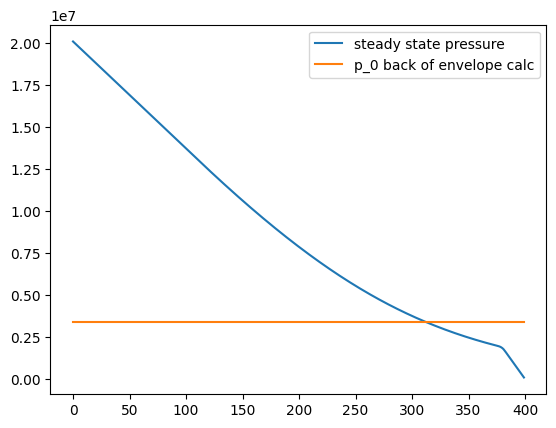

In [9]:
p_simple = p.ravel()

plt.plot(range(400), p_simple, label="steady state pressure")
plt.plot(range(400), np.ones(p_simple.shape)*3.4e6, label="p_0 back of envelope calc")
plt.legend()

## Relevant outputs from steady state solution

In [10]:
print(f"Chamber pressure: {p[0,0]} [Pa]")


Chamber pressure: 20110965.29332253 [Pa]


## Applying the chamber pressure as an IC for the dynamic simulation results in the following 

- I had to increase the exsolution timescale to about 1s in order to avoid an eruption.
- Why does the speed of sound drop so low leading up towards the plug? lower density I guess? More exsolved gas? 

In [6]:
os.chdir(target_dir)

from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

folder_name = "eruption_model_no_atmosphere"
file_name = "tungurahua_rad_5_v20_conduit"
iterations = 100
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iterations, viscosity_index=1, wall_friction_index=5, max_velocity=30, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=2000, max_water=20, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=1)

HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available